In [64]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [65]:
import pathlib

data_dir = pathlib.Path("DATA") # indiquer chemin  où sont les données

In [66]:
image_count = len(list(data_dir.glob('*/*'))) # compte le nb d'images dans le dossier
image_count

248

In [67]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) 
CLASS_NAMES # liste des noms de dossiers

array(['De', 'Pour,vers'], dtype='<U9')

In [68]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # 
BATCH_SIZE = image_count
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [69]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
#On importe les images

Found 248 images belonging to 2 classes.


In [70]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
#Fonction d'affichage des images

In [71]:
def show_batch_greyscale(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(np.squeeze(image_batch[n]),cmap = "gray")
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
#Fonction d'affichage des images grissées

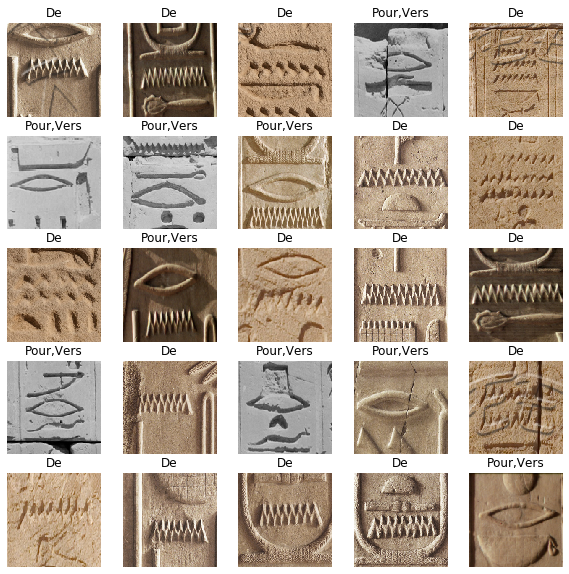

In [72]:
image_batch, label_batch = next(train_data_gen) #Pour séparer le label de l'image
show_batch(image_batch, label_batch)
#show_batch_greyscale(image_batch, label_batch)

In [73]:
image_batch.shape

(248, 224, 224, 3)

In [74]:
def augm(datagen):
    datagen.fit(image_batch)
    augmT = []
    for el in datagen.flow(image_batch,shuffle=False):
        for i in range(0, len(el)):
            if i == 0 : augmT.append(el[i])
            else : augmT.append(el[i])

        break
    augmT =  np.array(augmT)
    return augmT
        

In [75]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

In [76]:

#datagen = ImageDataGenerator(rotation_range=30)
#datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
#datagen = ImageDataGenerator(brightness_range=[0.9,1.01])
#datagen = ImageDataGenerator(fill_mode='constant')
#datagen = ImageDataGenerator(cval=255)
datagen = ImageDataGenerator(width_shift_range=[-50,50])

new_img =  np.concatenate((image_batch,augm(datagen)))
new_label =  np.concatenate((label_batch,label_batch))


In [77]:
"""label = []
for item in label_batch:
    label.append(np.argmax(item))
label = np.array(label)"""

'label = []\nfor item in label_batch:\n    label.append(np.argmax(item))\nlabel = np.array(label)'

In [78]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(image_batch, label_batch, test_size=0.25)

In [79]:
#sauvegarde weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="weights/checkpoint_tfl.h5",
                                                 save_weights_only=True,
                                                 verbose=1)

In [80]:
from keras.models import Sequential, Model
from keras import applications
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

In [81]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

In [82]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
history = model_final.fit(trainX, trainY, epochs=10, 
                    validation_data=(testX, testY))
#,callbacks=[cp_callback]

C:\Users\theoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Train on 186 samples, validate on 62 samples
Epoch 1/10
186/186 [==============================] - 134s 718ms/step - loss: 0.7445 - accuracy: 0.5376 - val_loss: 0.6320 - val_accuracy: 0.6290
Epoch 2/10
186/186 [==============================] - 136s 732ms/step - loss: 0.6740 - accuracy: 0.6505 - val_loss: 0.5331 - val_accuracy: 0.6452
Epoch 3/10
186/186 [==============================] - 134s 718ms/step - loss: 0.5480 - accuracy: 0.7258 - val_loss: 0.4704 - val_accuracy: 0.9355
Epoch 4/10
186/186 [==============================] - 130s 697ms/step - loss: 0.4718 - accuracy: 0.8118 - val_loss: 0.3523 - val_accuracy: 0.9032
Epoch 5/10
186/186 [==============================] - 127s 683ms/step - loss: 0.3777 - accuracy: 0.8387 - val_loss: 0.2814 - val_accuracy: 0.9032
Epoch 6/10
186/186 [==============================] - 133s 716ms/step - loss: 0.3075 - accuracy: 0.8978 - val_loss: 0.2162 - val_accuracy: 0.9677
Epoch 7/10
186/186 [==============================] - 128s 687ms/step - loss: 0

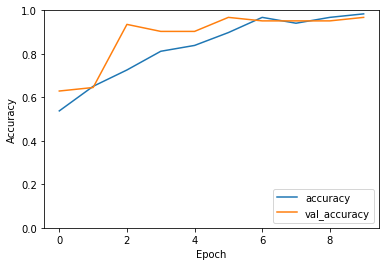

In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_final.evaluate(testX,  testY, verbose=2)

In [84]:
print(test_acc)

0.9677419066429138


In [85]:
pred = model_final.predict(image_batch)
pred[0]

array([0.97918916, 0.02081083], dtype=float32)

In [86]:
model_simi = Model(input = model.input, output =x)


C:\Users\theoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [ ]:
test = model_simi.predict(image_batch)

In [ ]:
from sklearn.manifold import TSNE
X = TSNE(n_components=3).fit_transform(test)

In [ ]:
quer = X[28]

In [ ]:
from scipy import spatial
X[spatial.KDTree(X).query(quer,k=6)[1]]

In [ ]:
distance,index = spatial.KDTree(X).query(quer,k=6)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for n in range(len(index)):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(np.squeeze(image_batch[index[n]]),cmap = "gray")
      plt.title(CLASS_NAMES[label_batch[index[n]]==1][0].title())
      plt.axis('off')